In [12]:
# This code is written to support the experiments in the book titled:
# "Adaptive Machine Learning Algorithms"
# by
# Chanchal Chatterjee and Vwani P. Roychowdhury
# August 2021
#
# Experiments for Chapter 6 - Accelerated Principal and Minor Eigenvectors of a Matrix Sequence
#
# Author: Chanchal Chatterjee
#
# Speedup of the Adaptive EVD Algorithm 
# Compare Our Steepest Descent, Yang's PASTd, Bannour/Sadjadi's RLS, Fu/Dowling's CGET1


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf


In [14]:
# Number of samples N and dimension D
nSamples = 1000
nDim     = 10
nEA      = 4
nEpochs  = 3


In [15]:
# Generate the covX random matrices
# cov = 3 * np.array([ \
#     [ 0.4270,  0.0110, -0.0050, -0.0250,  0.0890, -0.0790, -0.0190,  0.0740,  0.0890,  0.0050 ], \
#     [ 0.0110,  5.6900, -0.0690, -0.2820, -0.7310,  0.0900, -0.1240,  0.1000,  0.4320, -0.1030 ], \
#     [-0.0050, -0.0690,  0.0800,  0.0980,  0.0450, -0.0410,  0.0230,  0.0220, -0.0350,  0.0120 ], \
#     [-0.0250, -0.2820,  0.0980,  2.8000, -0.1070,  0.1500, -0.1930,  0.0950, -0.2260,  0.0460 ], \
#     [ 0.0890, -0.7310,  0.0450, -0.1070,  3.4400,  0.2530,  0.2510,  0.3160,  0.0390, -0.0100 ], \
#     [-0.0790,  0.0900, -0.0410,  0.1500,  0.2530,  2.2700, -0.1800,  0.2950, -0.0390, -0.1130 ], \
#     [-0.0190, -0.1240,  0.0230, -0.1930,  0.2510, -0.1800,  0.3270,  0.0270,  0.0260, -0.0160 ], \
#     [ 0.0740,  0.1000,  0.0220,  0.0950,  0.3160,  0.2950,  0.0270,  0.7270, -0.0960, -0.0170 ], \
#     [ 0.0890,  0.4320, -0.0350, -0.2260,  0.0390, -0.0390,  0.0260, -0.0960,  0.7150, -0.0090 ], \
#     [ 0.0050, -0.1030,  0.0120,  0.0460, -0.0100, -0.1130, -0.0160, -0.0170, -0.0090,  0.0650 ]])
cov = 2 * np.array([ \
    [ 0.0910,  0.0380, -0.0530, -0.0050,  0.0100, -0.1360,  0.1550,  0.0300,  0.0020,  0.0320 ], \
    [ 0.0380,  0.3730,  0.0180, -0.0280, -0.0110, -0.3670,  0.1540, -0.0570, -0.0310, -0.0650 ], \
    [-0.0530,  0.0180,  1.4300,  0.0170,  0.0550, -0.4500, -0.0380, -0.2980, -0.0410, -0.0300 ], \
    [-0.0050, -0.0280,  0.0170,  0.0840, -0.0050,  0.0160,  0.0420, -0.0220,  0.0010,  0.0050 ], \
    [ 0.0100, -0.0110,  0.0550, -0.0050,  0.0710,  0.0880,  0.0580, -0.0690, -0.0080,  0.0030 ], \
    [-0.1360, -0.3670, -0.4500,  0.0160,  0.0880,  5.7200, -0.5440, -0.2480,  0.0050,  0.0950 ], \
    [ 0.1550,  0.1540, -0.0380,  0.0420,  0.0580, -0.5440,  2.7500, -0.3430, -0.0110, -0.1200 ], \
    [ 0.0300, -0.0570, -0.2980, -0.0220, -0.0690, -0.2480, -0.3430,  1.4500,  0.0780,  0.0280 ], \
    [ 0.0020, -0.0310, -0.0410,  0.0010, -0.0080,  0.0050, -0.0110,  0.0780,  0.0670,  0.0150 ], \
    [ 0.0320, -0.0650, -0.0300,  0.0050,  0.0030,  0.0950, -0.1200,  0.0280,  0.0150,  0.3410 ]])
print(cov.shape)

(10, 10)


In [16]:
from scipy.linalg import eigh

eigvals, eigvecs = eigh(cov)
print("eigvals =\n", eigvals[::-1])

V = np.fliplr(eigvecs)
D  = np.diag(np.sqrt(eigvals[::-1]))
np.random.seed(1)
R = np.random.normal(0, 1, (nDim, nSamples))
X = V @ D @ R


eigvals =
 [11.79962474  5.56438753  3.41750617  2.0588796   0.78726809  0.5877646
  0.17426915  0.14232806  0.12129678  0.10067527]


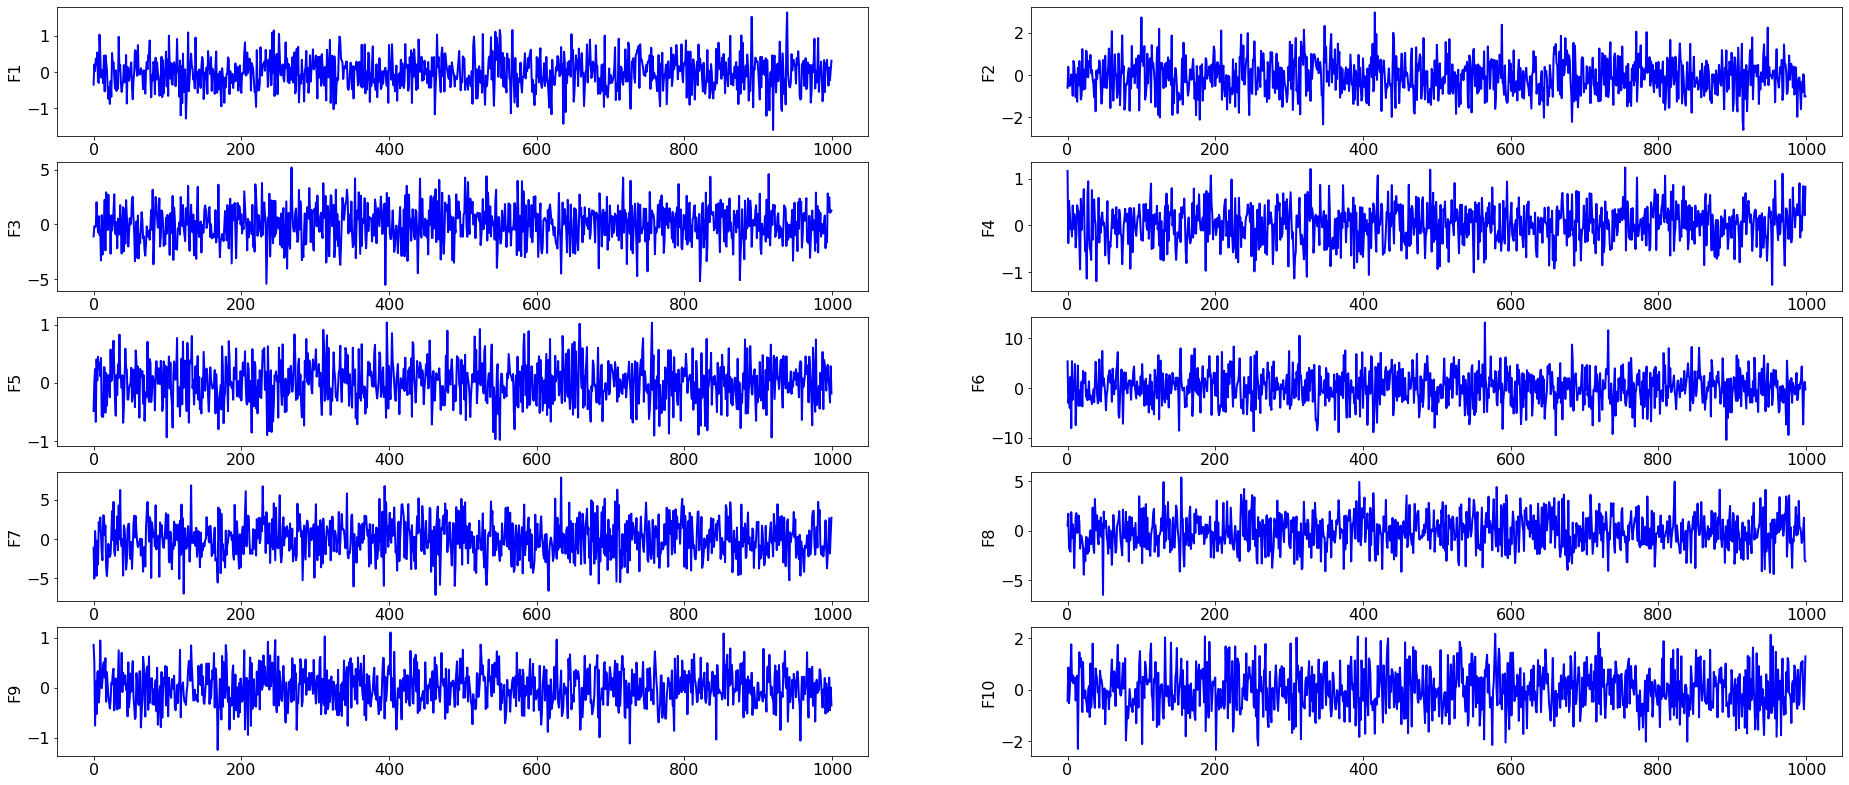

In [17]:
# Plot the data
dataset = pd.DataFrame(X.T, columns=['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10'])
plt.figure(figsize=(32, 48))
plt.rcParams.update({'font.size': 16})
cols = dataset.columns
for i in range(dataset.shape[1]):
    plt.subplot(17, 2, i+1)
    plt.ylabel(cols[i])
    plt.plot(dataset[cols[i]], lw=2, color='b')
plt.show()

In [18]:
# Square root of the correlation matrix
from scipy.linalg import eigh

# Compute Correlation matrix and eigen vectors of the generated data
corX = (X @ X.T) / nSamples

# Eigenvalues and eigenvectors of corX
eigvals, eigvecs = eigh(corX)
print("eigvals =\n", eigvals[::-1])

EstV = np.fliplr(eigvecs)
EstD  = np.diag(eigvals[::-1])


eigvals =
 [11.40359792  5.91075741  3.2191438   2.07590493  0.81885715  0.58123545
  0.16712483  0.1423136   0.12892165  0.08938132]


In [19]:
# Initialize all variables for adaptive algorithm
from numpy import linalg as la

A  = np.zeros(shape=(nDim,nDim)) # stores adaptive correlation matrix
W1 = 0.1 * np.ones(shape=(nDim,nEA)) # weight vectors of all algorithms
I  = np.identity(nDim)

# Initial Values for PASTd
W2 = 0.1 * np.ones(shape=(nDim,nEA)) # weight vectors of all algorithms
d  = 0.2 * np.ones(nEA)
y  = np.zeros(nEA)
E  = np.zeros(shape=(nDim,nEA))
XX  = np.zeros(shape=(nDim,nEA+1))
beta = 1.0

# Initial Values of RLS - Bannour/Sadjadi
W3 = 0.1 * np.ones(shape=(nDim,nEA)) # weight vectors of all algorithms
h  = np.zeros(nEA)
K  = np.zeros(nEA)
P  = np.ones(nEA)
dd = np.zeros(nDim)

# Initial Values of CGET1
W4 = 0.1 * np.ones(shape=(nDim,nEA)) # weight vectors of all algorithms
LL = np.zeros(nEA)
qq = np.zeros(nEA)
Residue = np.zeros(shape=(nDim,nEA))
PP = np.zeros(shape=(nDim,nEA))
XX = np.zeros(shape=(nDim,nEA+1))
for i in range(nEA):
    x = X[:,0].reshape(nDim,1)
    A1 = x @  x.T
    LL[i] = W4[:,i].T @ A1 @ W4[:,i]
    Residue[:,i] = (LL[i] * W4[:,i] - A1 @ W4[:,i]).T
    PP[:,i] = Residue[:,i]/la.norm(Residue[:,i])


In [20]:
# Adaptive algorithm
from numpy import linalg as la

cos_t1 = np.zeros(shape=(nEA, nSamples*nEpochs)) # cosine error
cos_t2 = np.zeros(shape=(nEA, nSamples*nEpochs)) # cosine error
cos_t3 = np.zeros(shape=(nEA, nSamples*nEpochs)) # cosine error
cos_t4 = np.zeros(shape=(nEA, nSamples*nEpochs)) # cosine error

for epoch in range(nEpochs):
    for iter in range(nSamples):
        cnt = nSamples*epoch + iter

        x = X[:,iter].reshape(nDim,1)
        A = A + (1.0/(1 + cnt))*((x @ x.T) - A)
        
        # Steepest Descent
        G = -2 * A @ W1 + A @ W1 @ np.triu(W1.T @ W1) + W1 @ np.triu(W1.T @ A @ W1)
        for i in range(nEA):
            M = np.zeros(shape=(nDim,nDim))
            for k in range(i):
                w1 = W1[:,k].reshape(nDim,1)
                M = M + (A @ (w1 @ w1.T) + (w1 @ w1.T) @ A)
         
            wi = W1[:,i].reshape(nDim,1)
            F = - 2*A + 2*A @ (wi @ wi.T) + 2 * (wi @ wi.T) @ A + A * (wi.T @ wi) + \
                    (wi.T @ A @ wi) * I  +  M
            gi = G[:,i].reshape(nDim,1)
            a0 = np.asscalar(gi.T @ gi)
            a1 = np.asscalar(- gi.T @ F @ gi)
            a2 = np.asscalar(3 * ((wi.T @ A @ gi) @ (gi.T @ gi) + (gi.T @ A @ gi)*(wi.T @ gi)))
            a3 = np.asscalar(- 2 * (gi.T @ A @ gi) @ (gi.T @ gi))
            c  = np.array([a3, a2, a1, a0])
            rts = np.roots(c)
         
            rs = np.zeros(3)
            r  = np.zeros(3)
            J  = np.zeros(3)

            cnt1 = 0
            for k in range(3):
                if np.isreal(rts[k]):
                    re = np.real(rts[k])
                    rs[cnt1] = re
                    r = W1[:,i] - re * G[:,i]
                    J[cnt1] = np.asscalar(-2*(r.T @ A @ r) + (r.T @ A @ r) * (r.T @ r) + (r.T @ M @ r))
                    cnt1 = cnt1 + 1
            yy = min(J)
            iyy = np.argmin(J)

            alpha = rs[iyy]
         
            W1[:,i] = (W1[:,i] - alpha * G[:,i]).T

            # PASTd - Yang
            XX[:,0] = X[:,iter].T
            for i in range(nEA):
                y[i] = W2[:,i].T @ XX[:,i]
                d[i] = beta * d[i] + y[i]*y[i]
                E[:,i] = (XX[:,i] - W2[:,i]*y[i]).T
                W2[:,i] = (W2[:,i] + E[:,i]*(y[i]/d[i])).T
                XX[:,i+1] = (XX[:,i] - W2[:,i]*y[i]).T
 
            # RLS - Bannour/Sadjadi
            for i in range(nEA):
                h[i] = W3[:,i].T @ X[:,iter]
                K[i] = (P[i]*h[i]) / (1 + h[i] * h[i] * P[i])
                dd = np.zeros(nDim)
                for j in range(i):
                    dd = dd + h[j]*W3[:,j]
                W3[:,i] = (W3[:,i] + K[i]*(X[:,iter] - dd - h[i]*W3[:,i])).T
                P[i] = (1 - K[i] * h[i]) * P[i]
                
#             # CGET1 - Fu/Dowling
#             for i in range(nEA):
#                 if ((PP[:,i].T @ A @ PP[:,i]) == 0):
#                     continue
#                 qq[i] = (Residue[:,i].T @ A @ PP[:,i]) / (PP[:,i].T @ A @ PP[:,i])
#                 PP[:,i] = (Residue[:,i] - qq[i]*PP[:,i]).T
#                 DD = np.zeros(shape=(nDim,nDim))
#                 for j in range(i):
#                     w4j = W4[:,j].reshape(nDim,1)
#                     DD = DD + w4j @ w4j.T
#                 BB = I - DD
#                 AA = BB.T @ A @ BB
#                 lx = W4[:,i].T @ AA @ W4[:,i]
#                 ax = W4[:,i].T @ AA @ PP[:,i]
#                 bx = PP[:,i].T @ AA @ PP[:,i]
#                 ex = W4[:,i].T @ BB @ W4[:,i]
#                 cx = W4[:,i].T @ BB @ PP[:,i]
#                 dx = PP[:,i].T @ BB @ PP[:,i]
#                 fx = bx*ex - lx*dx
#                 gx = ax*ex - lx*cx
#                 hx = bx*cx - ax*dx
#                 if (hx == 0):
#                     continue
#                 tx = (-fx - sqrt(fx**2 - 4*hx*gx))/(2*hx)
#                 XX[:,i] = (W4[:,i] + tx*PP[:,i]).T
#                 W4[:,i] = ((BB @ XX[:,i])/sqrt(XX[:,i].T @ BB @ XX[:,i])).T
#                 LL[i] = W4[:,i].T @ A @ W4[:,i]
#                 Residue[:,i] = (LL[i] * W4[:,i] - A @ W4[:,i]).T
 
        for i in range(nEA):
            u1 = (W1[:,i]/la.norm(W1[:,i])).reshape(nDim,1)
            u2 = (W2[:,i]/la.norm(W2[:,i])).reshape(nDim,1)
            u3 = (W3[:,i]/la.norm(W3[:,i])).reshape(nDim,1)
            #u4 = (W4[:,i]/la.norm(W4[:,i])).reshape(nDim,1)
            vi = EstV[:,i]
            cos_t1[i,cnt] = abs(u1.T @ vi)
            cos_t2[i,cnt] = abs(u2.T @ vi)
            cos_t3[i,cnt] = abs(u3.T @ vi)
            #cos_t4[i,cnt] = abs(u4.T @ vi)


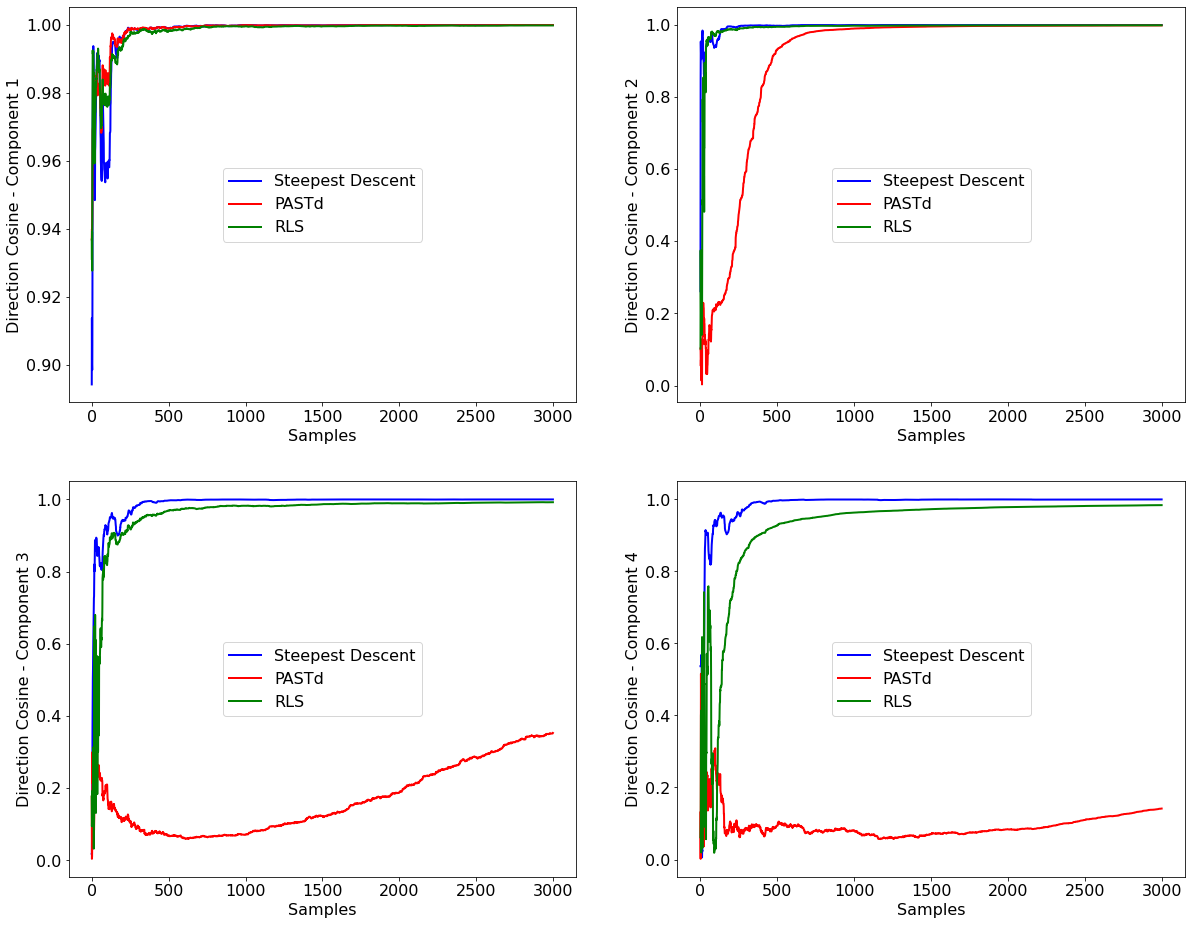

In [21]:
plt.figure(figsize=(20, 16))
plt.rcParams.update({'font.size': 16})

plt.subplot(2, 2, 1)
plt.plot(cos_t1[0,:], lw=2, color='b', label='Steepest Descent')
plt.plot(cos_t2[0,:], lw=2, color='r', label='PASTd')
plt.plot(cos_t3[0,:], lw=2, color='g', label='RLS')
#plt.plot(cos_t4[0,:], lw=2, color='k', label='CGET1')
plt.ylabel('Direction Cosine - Component 1')
plt.xlabel('Samples')
plt.legend(loc="center")

plt.subplot(2, 2, 2)
plt.plot(cos_t1[1,:], lw=2, color='b', label='Steepest Descent')
plt.plot(cos_t2[1,:], lw=2, color='r', label='PASTd')
plt.plot(cos_t3[1,:], lw=2, color='g', label='RLS')
#plt.plot(cos_t4[1,:], lw=2, color='k', label='CGET1')
plt.ylabel('Direction Cosine - Component 2')
plt.xlabel('Samples')
plt.legend(loc="center")

plt.subplot(2, 2, 3)
plt.plot(cos_t1[2,:], lw=2, color='b', label='Steepest Descent')
plt.plot(cos_t2[2,:], lw=2, color='r', label='PASTd')
plt.plot(cos_t3[2,:], lw=2, color='g', label='RLS')
#plt.plot(cos_t4[2,:], lw=2, color='k', label='CGET1')
plt.ylabel('Direction Cosine - Component 3')
plt.xlabel('Samples')
plt.legend(loc="center")

plt.subplot(2, 2, 4)
plt.plot(cos_t1[3,:], lw=2, color='b', label='Steepest Descent')
plt.plot(cos_t2[3,:], lw=2, color='r', label='PASTd')
plt.plot(cos_t3[3,:], lw=2, color='g', label='RLS')
#plt.plot(cos_t4[3,:], lw=2, color='k', label='CGET1')
plt.ylabel('Direction Cosine - Component 4')
plt.xlabel('Samples')
plt.legend(loc="center")

plt.show()